In [2]:
import importlib
import math
from dataclasses import dataclass
from abc import abstractmethod, ABC
from collections.abc import Callable, Sequence
import warnings

from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from numpy.typing import ArrayLike
from numpy.polynomial.hermite import hermgauss
import scipy
from scipy.special import ndtr, ndtri
from scipy.stats.distributions import lognorm
from scipy.interpolate import PchipInterpolator, CubicSpline
from scipy.integrate import simpson, quad

from src import bs

# Data

## Prices

In [3]:
TENORS = [1, 2]
SPOT = 1
VOL = 0.2

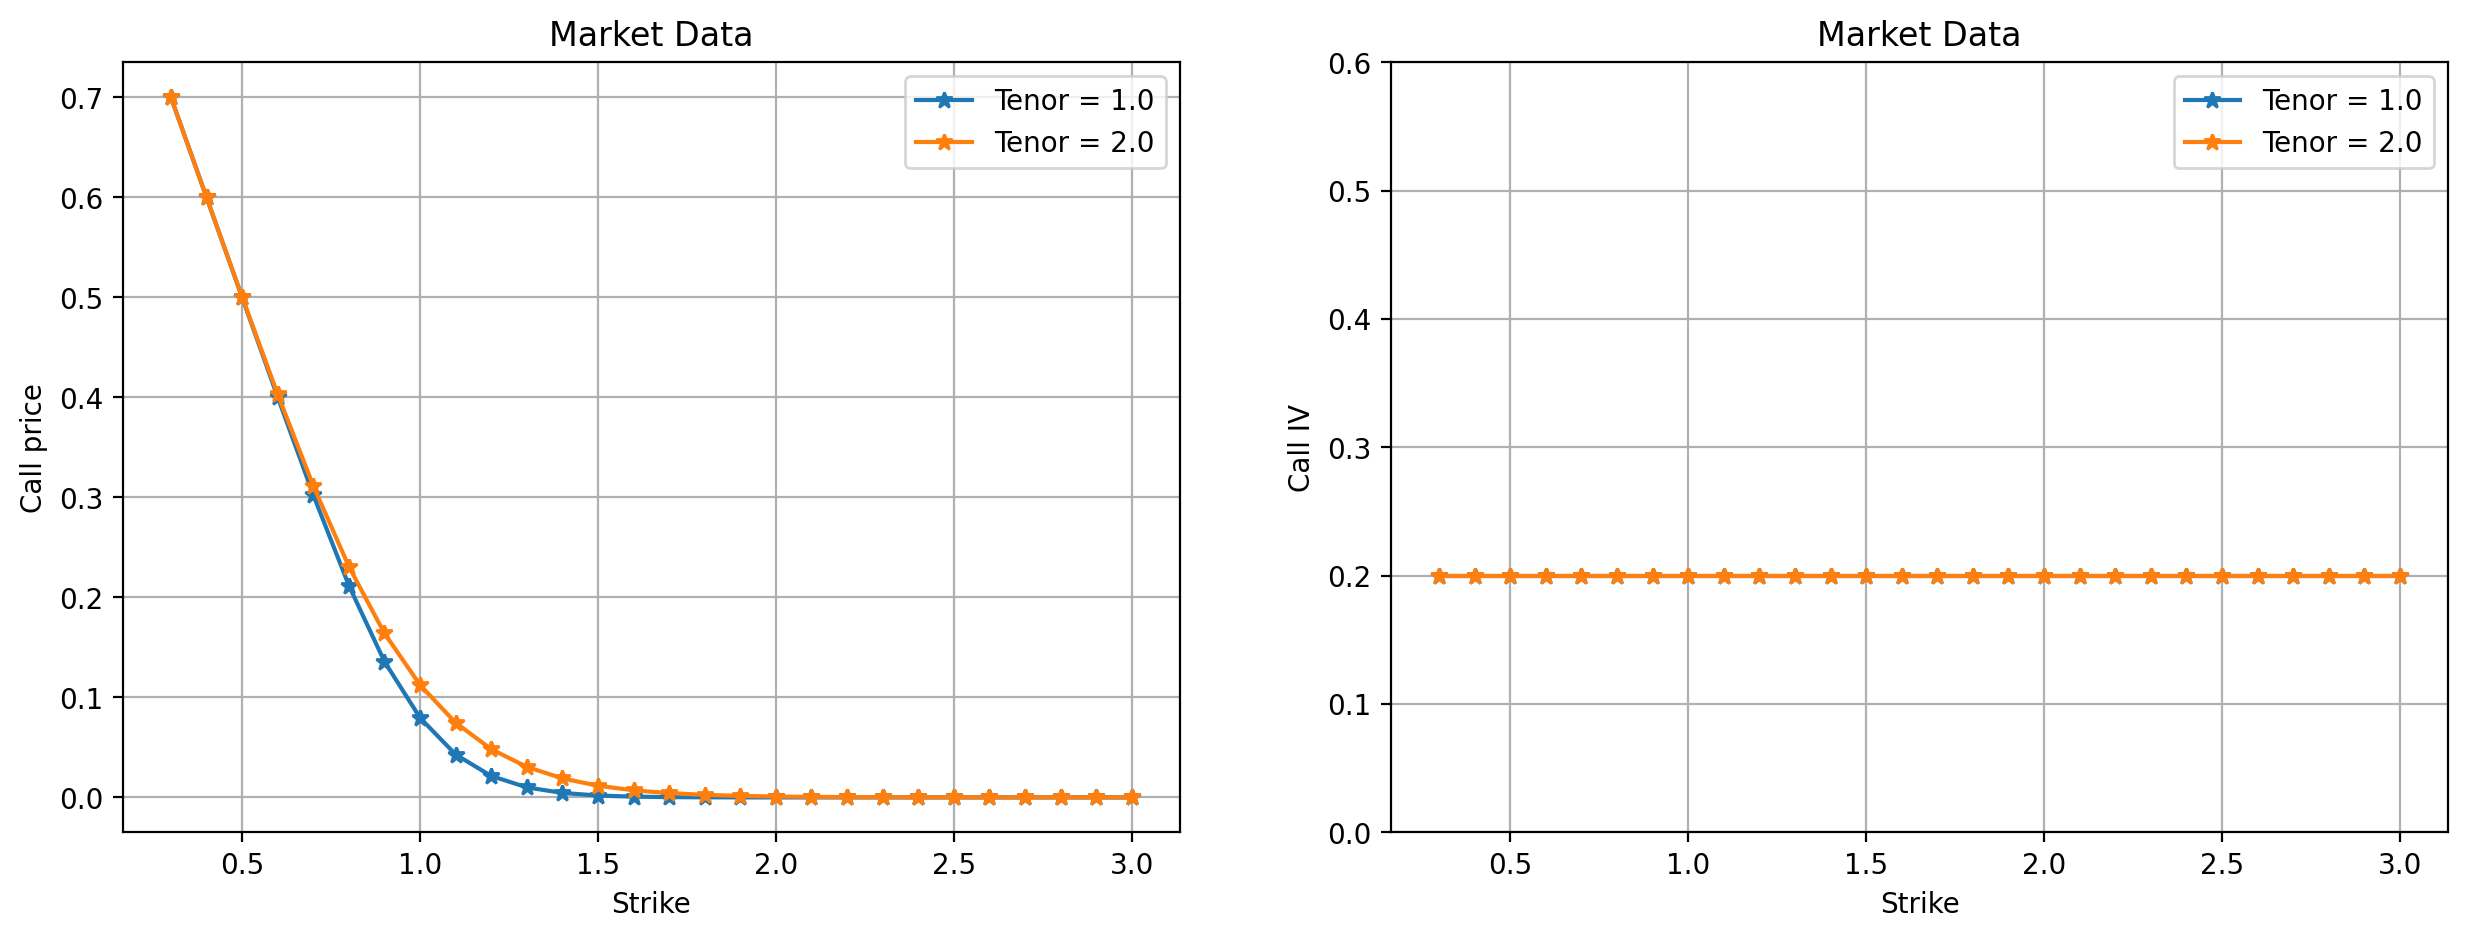

In [4]:
_, (ax_p, ax_iv) = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

strike_grid = np.linspace(0.3, 3, 28)
prices = [bs.call_price(1, strike_grid, tenor, VOL) for tenor in TENORS]
ivs = [bs.call_iv(SPOT, strike_grid, T, p) for p, T in zip(prices, TENORS)]

for iv, p, T in zip(ivs, prices, TENORS):
    ax_p.plot(strike_grid, p, "-*", label=f"Tenor = {T:.1f}")
    ax_iv.plot(strike_grid, iv, "-*", label=f"Tenor = {T:.1f}")

ax_iv.set_xlabel("Strike")
ax_iv.set_ylabel("Call IV")
ax_iv.set_title("Market Data")
ax_iv.legend()
ax_iv.grid()
ax_iv.set_ylim(0, 0.6)

ax_p.set_xlabel("Strike")
ax_p.set_ylabel("Call price")
ax_p.set_title("Market Data")
ax_p.legend()
ax_p.grid()

plt.show()

## Marginals

In [5]:
class Marginal(ABC):

    @property
    @abstractmethod
    def tenor(self) -> float:
        pass

    @abstractmethod
    def cdf(self, x: ArrayLike) -> ArrayLike:
        pass
        
    @abstractmethod
    def icdf(self, u: ArrayLike) -> ArrayLike:
        pass
        
    @abstractmethod
    def iicdf(self, u: ArrayLike) -> ArrayLike:
        pass        
    
    @abstractmethod
    def dicdf(self, u: ArrayLike) -> ArrayLike:
        pass

In [6]:
class MarginalInterp(Marginal):
    def __init__(
        self,
        strikes: np.ndarray,
        cdf_vals: np.ndarray,
        tenor: float,
    ):
        assert len(strikes > 3)
        self._t = tenor
        self._nodes = strikes
        self._eps = np.finfo(cdf_vals.dtype).eps
        self._cdf_vals = cdf_vals
        assert all(self._cdf_vals <= 1) and all(self._cdf_vals >= 0)
        assert all(np.gradient(self._cdf_vals) >= 0)

        # linear extrapolation of cdf
        k1, k2 = self._nodes[-2:]
        y1, y2 = self._cdf_vals[-2:]
        k_max = k1 + (1 - y1) / (y2 - y1) * (k2 - k1)
        self._nodes = np.append(self._nodes, k_max)
        self._cdf_vals = np.append(self._cdf_vals, 1 - self._eps)
        
        k1, k2 = self._nodes[:2]
        y1, y2 = self._cdf_vals[:2]
        k_min = k1 + (0 - y1) / (y2 - y1) * (k2 - k1)
        self._nodes = np.insert(self._nodes, 0, k_min)
        self._cdf_vals = np.insert(self._cdf_vals, 0, self._eps)

        self._cdf = PchipInterpolator(self._nodes, self._cdf_vals, extrapolate=True)
        self._icdf = PchipInterpolator(self._cdf_vals, self._nodes, extrapolate=True)
        self._iicdf = self._icdf.antiderivative()
        self._dicdf = self._icdf.derivative()

    @classmethod
    def from_call_prices(
        cls,
        strikes: np.ndarray,
        prices: np.ndarray,
        tenor: float,
    ):
        cdf_vals = 1 + np.gradient(prices, strikes)
        return cls(strikes, cdf_vals, tenor)

    @property
    def tenor(self):
        return self._t

    @property
    def nodes(self):
        return self._nodes[1:-1]

    def cdf(self, x):
        return np.clip(self._cdf(x), self._eps, 1 - self._eps)

    def icdf(self, u):
        return self._icdf(u)

    def iicdf(self, u):
        return self._iicdf(u) - self._iicdf(0)

    def dicdf(self, u):
        return self._dicdf(u)

In [7]:
class MarginalLogNormal(Marginal):
    def __init__(
        self,
        tenor: float,
        vola: float,
    ):
        self._t = tenor
        self._sigma = vola * np.sqrt(tenor)

    @property
    def tenor(self):
        return self._t

    def cdf(self, x):
        eps = np.finfo(x.dtype).eps
        LB = eps
        UB = 1 - eps
        u = ndtr((np.log(x) + self._sigma ** 2 / 2) / self._sigma)
        return np.clip(u, LB, UB)

    def icdf(self, u):
        eps = np.finfo(u.dtype).eps
        LB = eps
        UB = 1 - eps
        u = np.clip(u, LB, UB)
        return np.exp(self._sigma * ndtri(u) - self._sigma**2 / 2)

    def iicdf(self, u):
        k = self.icdf(u)
        d1 = (-np.log(k) + self._sigma**2 / 2) / self._sigma
        return 1 - ndtr(d1)

    def dicdf(self, u):
        x = self.icdf(u)
        return np.sqrt(2 * np.pi) * self._sigma * np.exp((np.log(x) + self._sigma**2 / 2)**2 / self._sigma**2 / 2)

In [8]:
marginals_an = [
    MarginalLogNormal(tenor, VOL) for tenor in TENORS
]
marginals_in = [
    MarginalInterp.from_call_prices(strike_grid, p, tenor) 
    for p, tenor in zip(prices, TENORS)
]

x_grid = np.linspace(0.1, 3, 500)
u_grid = np.linspace(1e-5, 1 - 1e-5, 500)

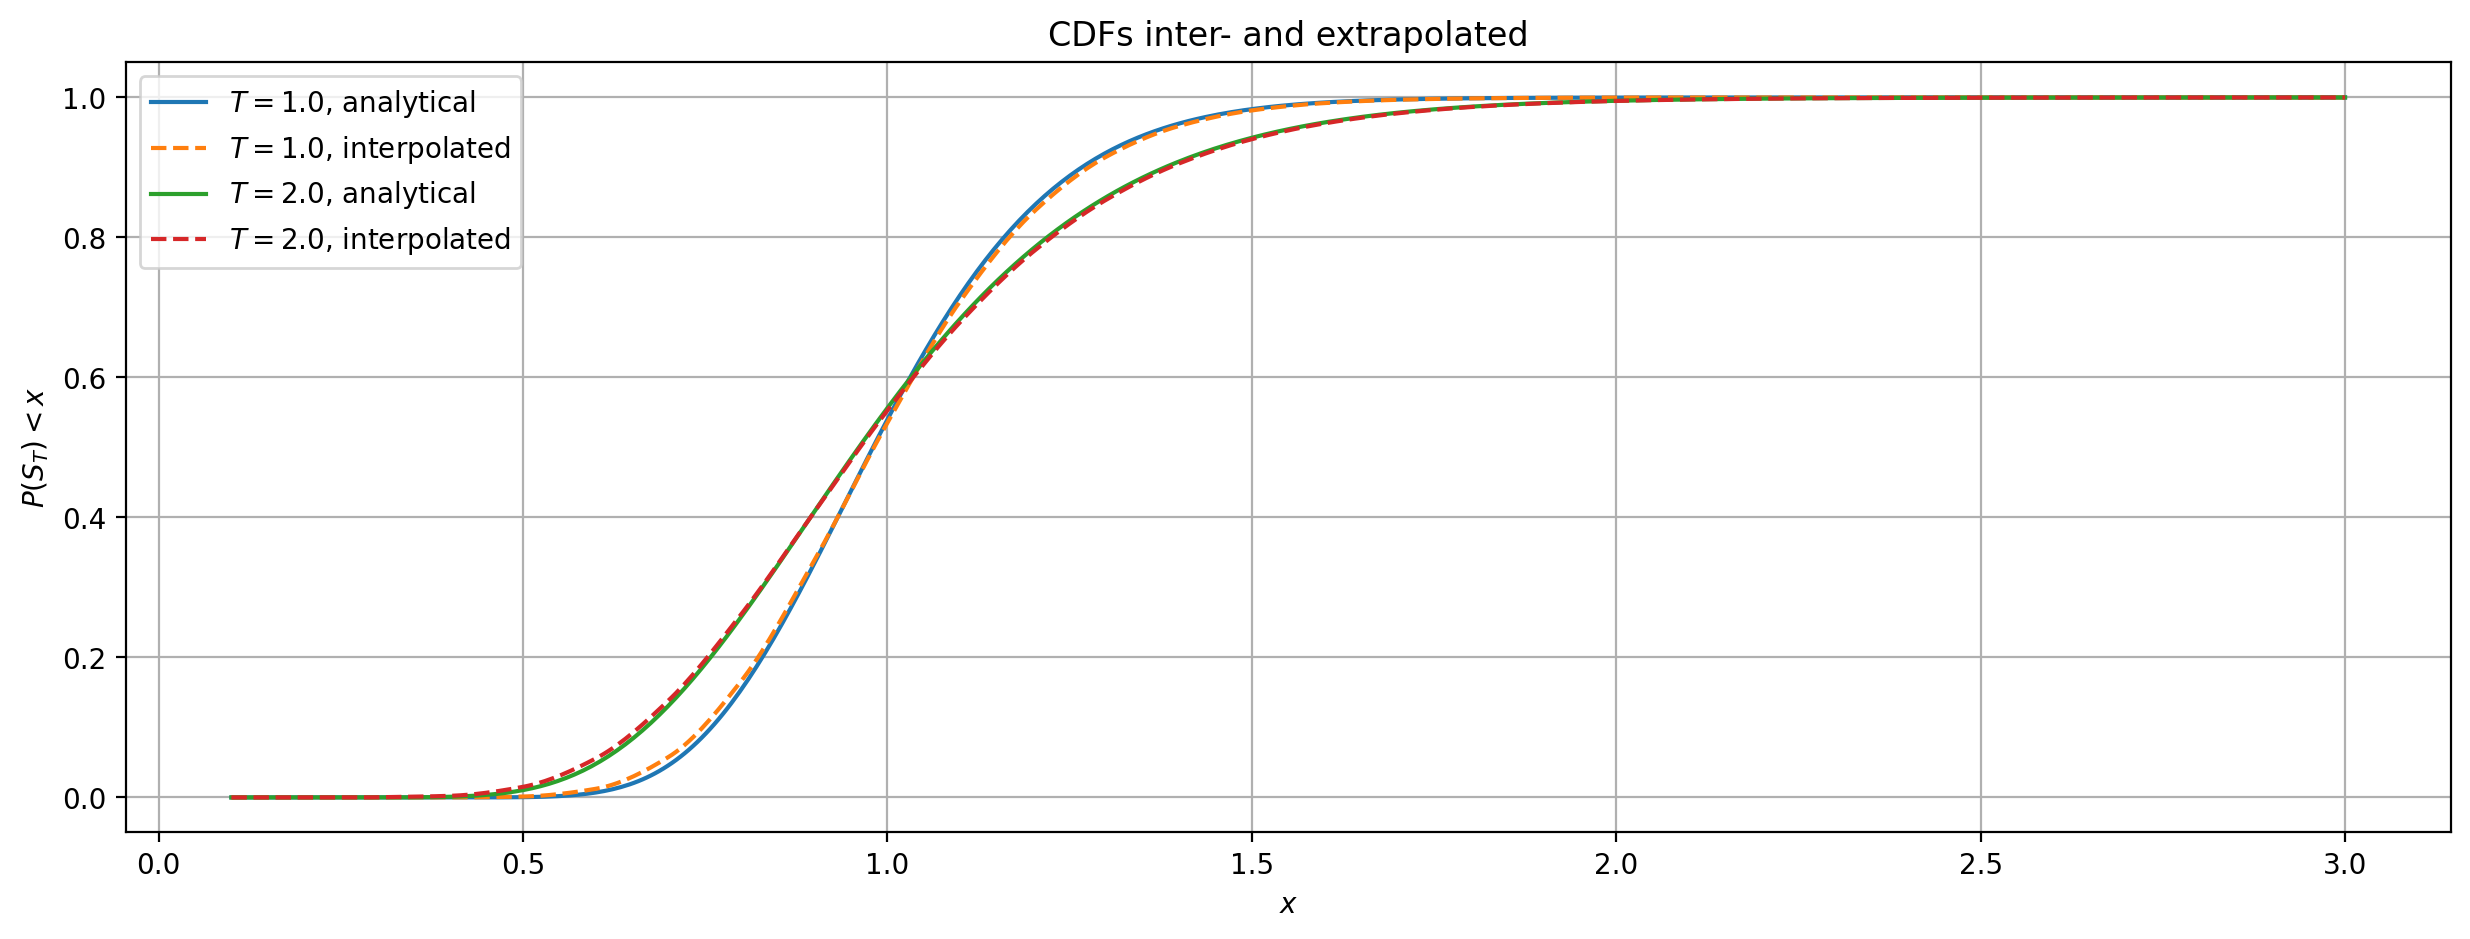

In [9]:
_, ax = plt.subplots(figsize=(15, 5), dpi=200)

for m_an, m_in in zip(marginals_an, marginals_in):
    ax.plot(x_grid, m_an.cdf(x_grid), label=f"$T = {m_an.tenor:.1f}$, analytical")
    ax.plot(x_grid, m_in.cdf(x_grid), label=f"$T = {m_in.tenor:.1f}$, interpolated", ls="--")

ax.legend()
ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$P(S_T) < x$")
ax.set_title("CDFs inter- and extrapolated")

plt.show()

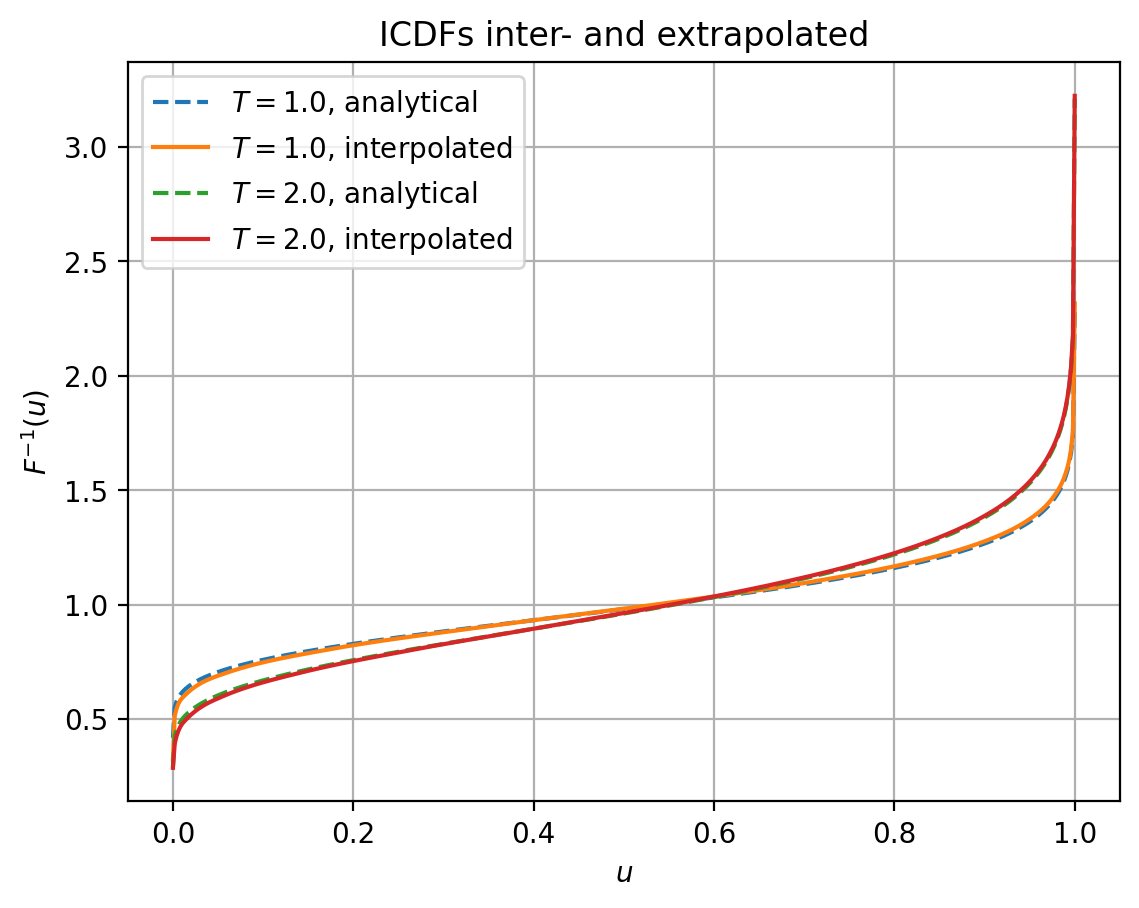

In [10]:
_, ax = plt.subplots(dpi=200)

for m_an, m_in in zip(marginals_an, marginals_in):
    ax.plot(u_grid, m_an.icdf(u_grid), label=f"$T = {m_an.tenor:.1f}$, analytical", ls="--")
    ax.plot(u_grid, m_in.icdf(u_grid), label=f"$T = {m_in.tenor:.1f}$, interpolated")

ax.legend()
ax.grid()
ax.set_xlabel("$u$")
ax.set_ylabel("$F^{-1}(u)$")
ax.set_title("ICDFs inter- and extrapolated")

plt.show()

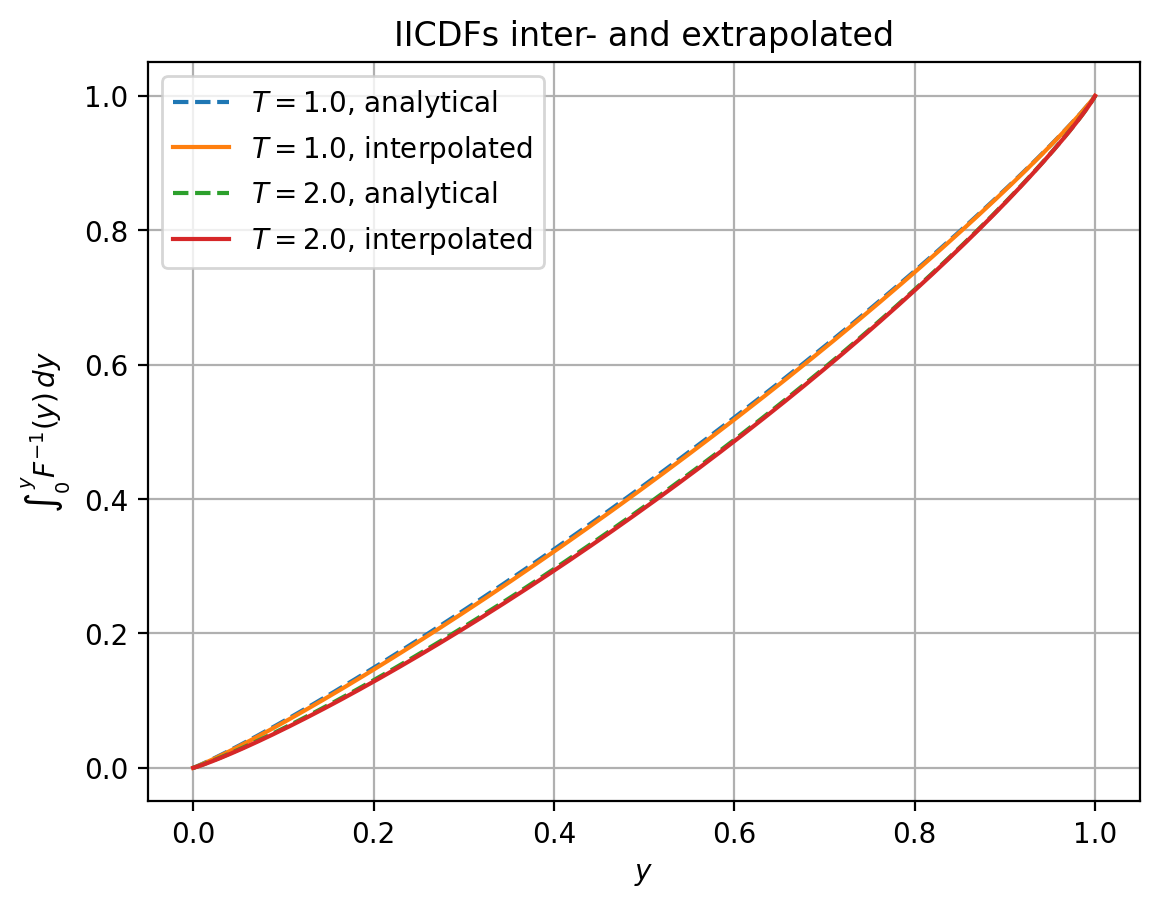

In [11]:
_, ax = plt.subplots(dpi=200)

for m_an, m_in in zip(marginals_an, marginals_in):
    ax.plot(u_grid, m_an.iicdf(u_grid), label=f"$T = {m_an.tenor:.1f}$, analytical", ls="--")
    ax.plot(u_grid, m_in.iicdf(u_grid), label=f"$T = {m_in.tenor:.1f}$, interpolated")
    
ax.legend()
ax.grid()
ax.set_xlabel("$y$")
ax.set_ylabel(r"$\int_0^y F^{-1}(y)\,dy$")
ax.set_title("IICDFs inter- and extrapolated")

plt.show()

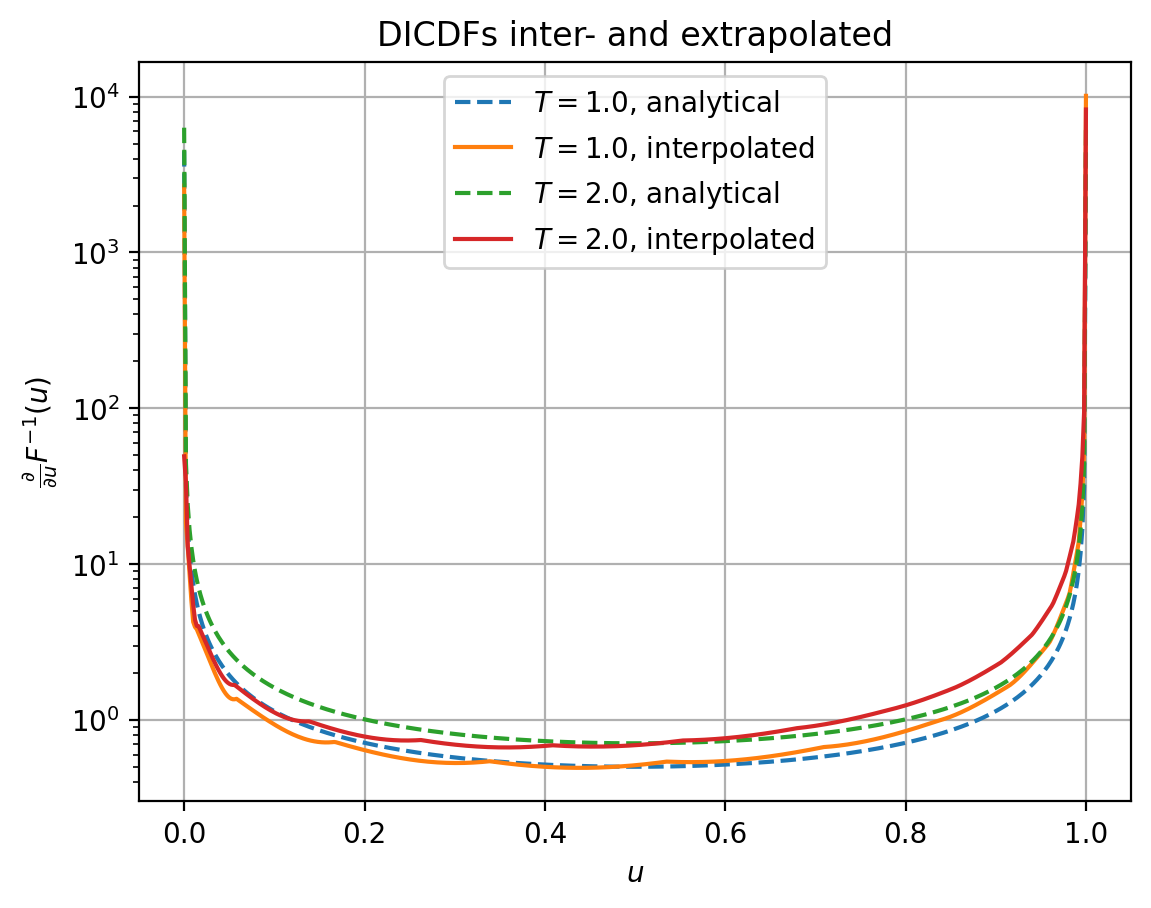

In [12]:
_, ax = plt.subplots(dpi=200)

for m_an, m_in in zip(marginals_an, marginals_in):
    ax.plot(u_grid, m_an.dicdf(u_grid), label=f"$T = {m_an.tenor:.1f}$, analytical", ls="--")
    ax.plot(u_grid, m_in.dicdf(u_grid), label=f"$T = {m_in.tenor:.1f}$, interpolated")

ax.legend()
ax.grid()
ax.set_xlabel("$u$")
ax.set_ylabel(r"$\frac{\partial}{\partial u} F^{-1}(u)$")
ax.set_title("DICDFs inter- and extrapolated")
ax.set_yscale("log")

plt.show()

# One marginal Bass construction

In [13]:
marginals = [MarginalLogNormal(tenor, VOL) for tenor in TENORS]

## Convolution

In [14]:
def conv_heat_gauss_hermite(
    t: np.ndarray,
    func: Callable[[np.ndarray], np.ndarray],
    n_quad: int = 20,
) -> Callable[[np.ndarray], np.ndarray]:
    nodes, weights = hermgauss(n_quad)

    def f(x):
        x_b, t_b= np.broadcast_arrays(x, t)
        target_shape = (-1, *(1,) * x_b.ndim)
        x_b, t_b = x_b[None], t_b[None]
        
        scale = np.sqrt(2 * t_b + np.finfo(np.float64).eps)
        nodes_scaled = nodes.reshape(target_shape) * scale
        weights_reshaped = weights.reshape(target_shape)
        
        y = x_b - nodes_scaled
        func_vals = func(y)
        return np.sum(func_vals * weights_reshaped / np.sqrt(np.pi), axis=0)

    return f

In [15]:
def f_analytical(t, w):
    return np.exp(VOL * w - VOL**2 * t / 2)

In [16]:
def f_numerical(t, w, marginal: Marginal, n_quad=20):
    eps = np.finfo(t.dtype).eps
    conv_f = conv_heat_gauss_hermite(
        marginal.tenor - t,
        lambda x: marginal.icdf(ndtr(x / np.sqrt(TENORS[0]))),
        n_quad=n_quad,
    )
    return conv_f(w)

In [17]:
w_flat = np.linspace(-3, 3, 300)
t_flat = np.linspace(0, 1, 100)
t, w = np.meshgrid(t_flat, w_flat)

In [18]:
vals_a = f_analytical(t, w)

In [19]:
vals_n = f_numerical(t, w, marginals[0])

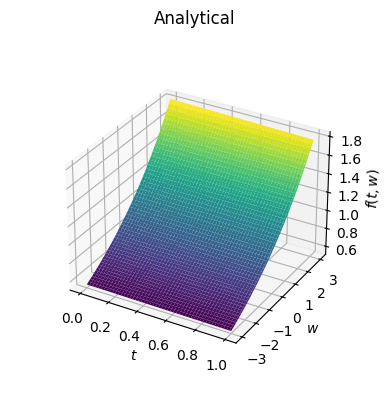

In [20]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(t, w, vals_a, cmap=cm.viridis)

ax.set_xlabel("$t$")
ax.set_ylabel("$w$")
ax.set_zlabel("$f(t, w)$")
ax.set_title("Analytical")
ax.set_box_aspect(None, zoom=0.8)

plt.show()

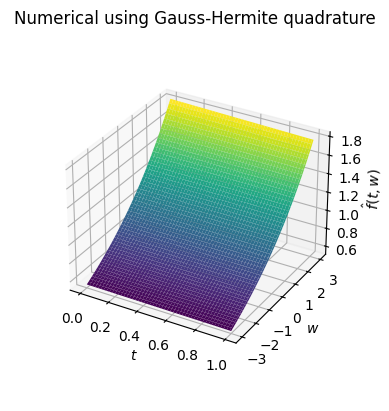

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(t, w, vals_n, cmap=cm.viridis)

ax.set_xlabel("$t$")
ax.set_ylabel("$w$")
ax.set_zlabel(r"$\hat f(t, w)$")
ax.set_title("Numerical using Gauss-Hermite quadrature")
ax.set_box_aspect(None, zoom=0.8)

plt.show()

/tmp/ipykernel_919770/4008491564.py:3: RuntimeWarning: divide by zero encountered in log10
  surf = ax.plot_surface(t, w, np.log10(np.fabs(vals_n - vals_a)), cmap=cm.viridis)


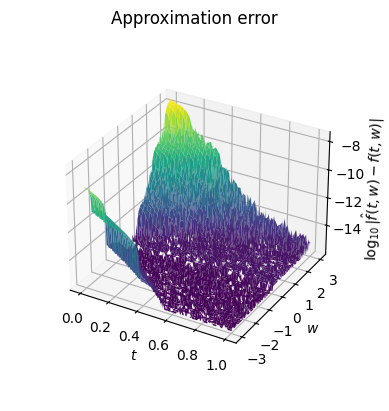

In [22]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(t, w, np.log10(np.fabs(vals_n - vals_a)), cmap=cm.viridis)

ax.set_xlabel("$t$")
ax.set_ylabel("$w$")
ax.set_zlabel(r"$\log_{10} | \hat f(t, w) - f(t, w) |$")
ax.set_title("Approximation error")
ax.set_box_aspect(None, zoom=0.8)

plt.show()

## $f(t, w)$ on $[0, T_1]$

In [23]:
N_PATHS = 7
rng = np.random.default_rng(0xB0BA_C_3AB0DA)

In [24]:
def f_01(t, w):
    return f_numerical(t, w, marginals[0])

In [25]:
dB_t = rng.normal(size=(N_PATHS, len(t_flat))) * np.sqrt(np.diff(t_flat, prepend=0))
B_t = np.cumsum(dB_t, axis=1)

In [26]:
S_t_gt = np.exp(-VOL**2 / 2 * t_flat + VOL * B_t)
S_t_bass_f_an = f_analytical(t_flat, B_t)
S_t_bass = f_01(t_flat, B_t)

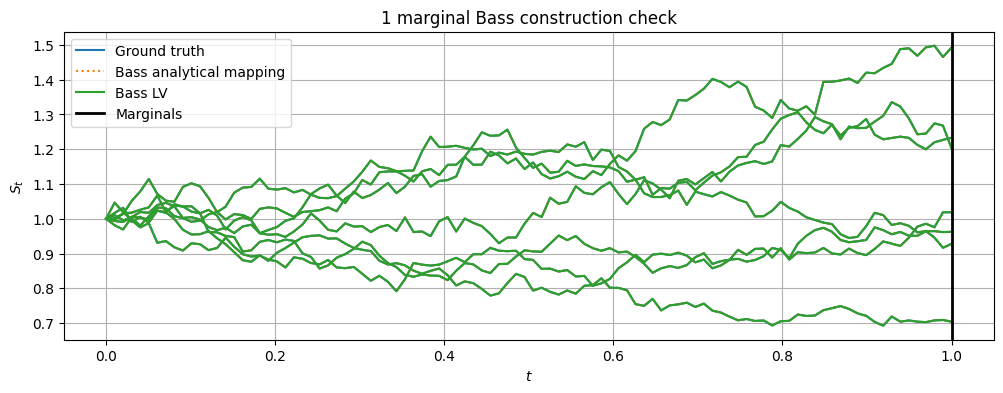

In [27]:
_, ax = plt.subplots(figsize=(12, 4))

handle_gt, *_ = ax.plot(t_flat, S_t_gt.T, c="C0")
handle_bass_an, *_ = ax.plot(t_flat, S_t_gt.T, c="C1", ls=":")
handle_bass, *_ = ax.plot(t_flat, S_t_bass.T, c="C2")
handle_marginal = ax.axvline(marginals[0].tenor, c="k", lw=2)

ax.set_xlabel("$t$")
ax.set_ylabel("$S_t$")
ax.set_title("1 marginal Bass construction check")
ax.grid()
ax.legend(
    [
        handle_gt,
        handle_bass_an,
        handle_bass,
        handle_marginal,
    ],
    [
        "Ground truth",
        "Bass analytical mapping",
        "Bass LV",
        "Marginals",
    ],
)

plt.show()

slightly wider

# Multi-Marginal

## Solving fixed-point equation

In [28]:
class AuxCDF:
    def __init__(
        self,
        grid: ArrayLike,
        vals: ArrayLike,
    ):
        self._w_grid = grid
        self._cdf = PchipInterpolator(grid, vals)
        self._icdf = PchipInterpolator(vals, grid)

    @classmethod
    def build_initial_approx(
        cls,
        m1: Marginal,
        m2: Marginal,
        grid_points: int = 300,
        interp_bounds_stds: float = 5,
    ):
        eps = np.finfo(np.float64).eps
        assert interp_bounds_stds < -ndtri(eps)
        
        raw_w_grid = np.linspace(-interp_bounds_stds, interp_bounds_stds, grid_points)
        u_grid = ndtr(raw_w_grid)

        integrand = np.sqrt(
            m2.dicdf(u_grid) / (m1.iicdf(u_grid) - m2.iicdf(u_grid) + eps)
        )
        integral = CubicSpline(u_grid, integrand).antiderivative()
        icdf_vals = (
            np.sqrt((m2.tenor - m1.tenor) / 2) * (integral(u_grid) - integral(1 / 2))
        )

        w_grid = raw_w_grid * np.sqrt(m1.tenor)
        return cls(w_grid, PchipInterpolator(icdf_vals, u_grid)(w_grid))

    @property
    def grid(self):
        return np.copy(self._w_grid)

    def __call__(self, w):
        return self._cdf(w)

    def icdf(self, u):
        return self._icdf(u)

In [29]:
m1, m2 = marginals

cdf_init = AuxCDF.build_initial_approx(m1, m2, 1000, 5)

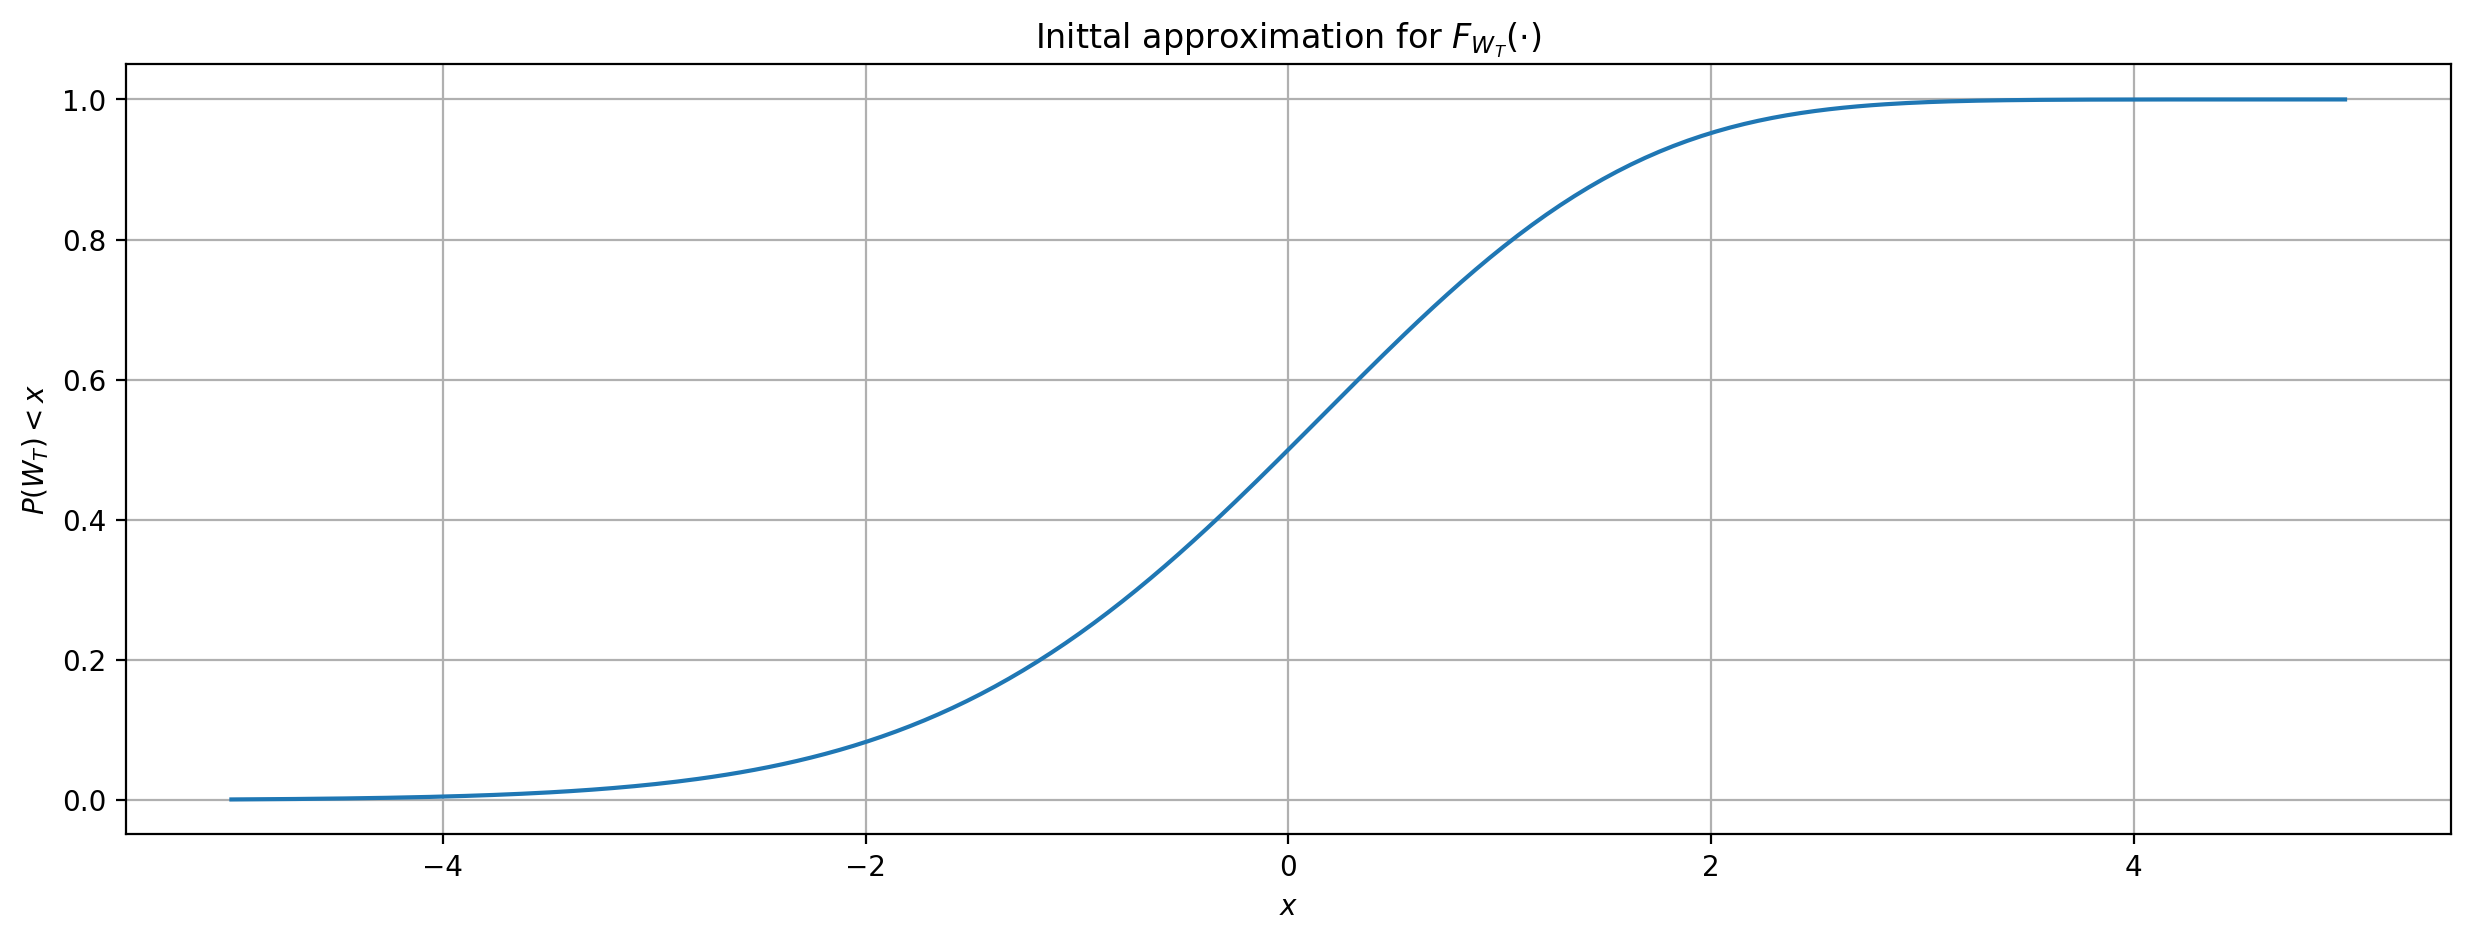

In [30]:
_, ax = plt.subplots(figsize=(15, 5), dpi=200)

w = np.linspace(-5, 5, 300)
ax.plot(w, cdf_init(w))

ax.grid()
ax.set_xlabel("$x$")
ax.set_ylabel("$P(W_T) < x$")
ax.set_title(r"Inittal approximation for $F_{W_T}(\cdot)$")

plt.show()

In [31]:
def apply_operator(cdf: AuxCDF, m1: Marginal, m2: Marginal) -> AuxCDF:
    dt = m2.tenor - m1.tenor
    assert dt > 0
    
    kf = conv_heat_gauss_hermite(dt, cdf)
    fkf = lambda u: m2.icdf(kf(u))
    kfkf = conv_heat_gauss_hermite(dt, fkf)
    fkfkf = lambda x: m1.cdf(kfkf(x))

    new_vals = fkfkf(cdf.grid)
    new_cdf = AuxCDF(cdf.grid, new_vals)
    return new_cdf

In [32]:
def solve_fixed_point(m1: Marginal, m2: Marginal, w2_tol=1e-3, max_iters=100) -> AuxCDF:

    w2 = np.inf
    cdf = AuxCDF.build_initial_approx(m1, m2)
    for _ in range(max_iters):
        new_cdf = apply_operator(cdf, m1, m2)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            w2_sq, errsq = quad(lambda u: (new_cdf.icdf(u) - cdf.icdf(u))**2, 0, 1)
        w2 = np.sqrt(w2_sq)
        cdf = new_cdf
        if w2 < w2_tol - errsq:
            break
    else:
        warnings.warn(f"Maximum number of iterations reached, W2 error = {w2:.1e}", RuntimeWarning)

    return cdf

In [33]:
cdf = solve_fixed_point(m1, m2)

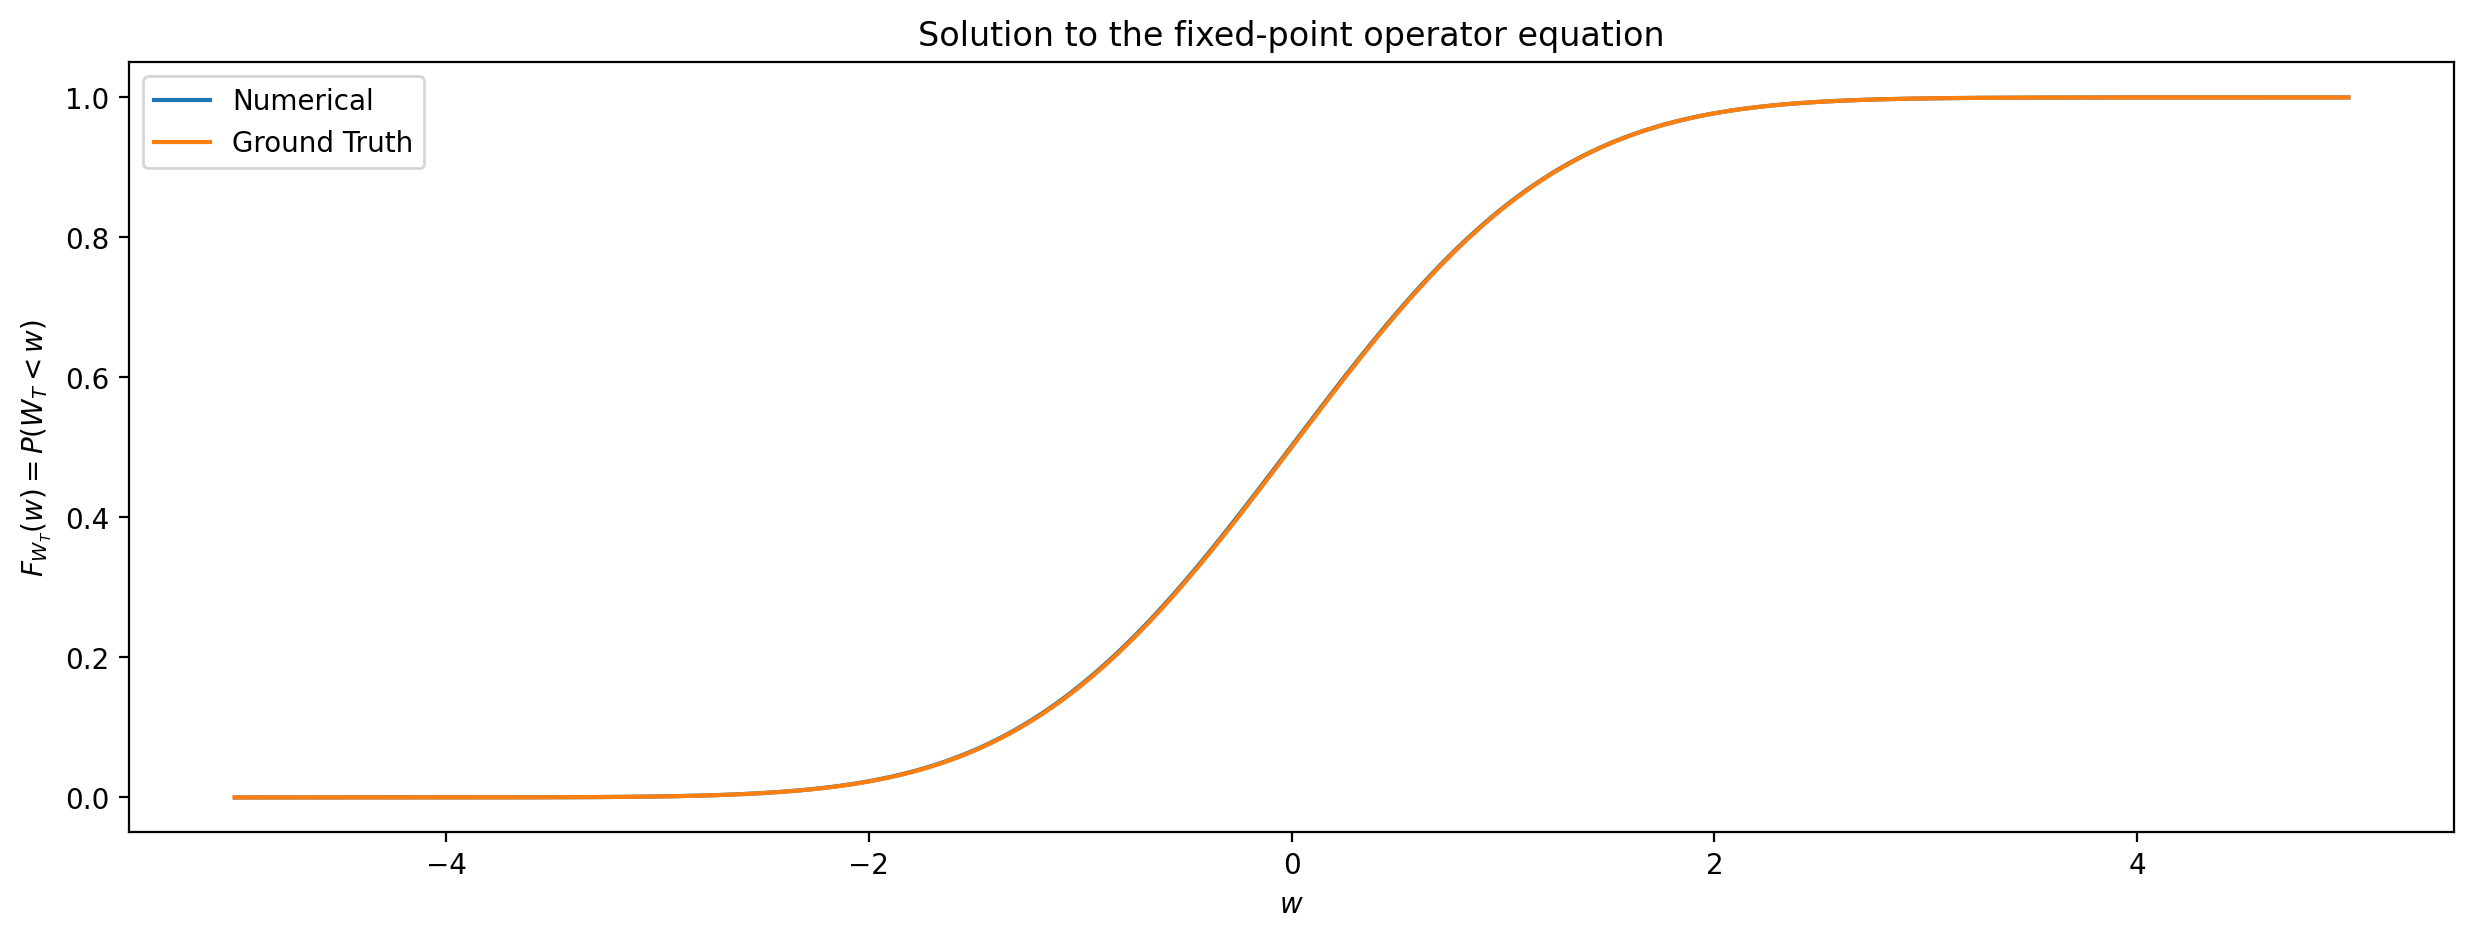

In [34]:
_, ax = plt.subplots(figsize=(15, 5), dpi=200)

x = np.linspace(-5, 5, 1000)
num = cdf(x)
gt = ndtr(x * np.sqrt(TENORS[0]))

ax.plot(x, num, label="Numerical")
ax.plot(x, gt, label="Ground Truth")
ax.set_title("Solution to the fixed-point operator equation")
ax.set_xlabel("$w$")
ax.set_ylabel("$F_{W_T}(w) = P(W_T < w)$")
ax.legend()

plt.show()

In [35]:
err_l_inf = np.max(np.abs(num - gt))

icdf_gt = lambda u: np.sqrt(TENORS[0]) * ndtri(u)
err_w2, w2_est_err =  quad(lambda u: (icdf_gt(u) - cdf.icdf(u))**2, 0, 1)

print(f"L_inf error: {err_l_inf:.1e}")
print(f"W_2 error: {np.sqrt(err_w2):.1e} ± {np.sqrt(w2_est_err):.1e}")

L_inf error: 2.1e-03
W_2 error: 5.5e-03 ± 1.0e-04


In [36]:
kf = conv_heat_gauss_hermite(m2.tenor - m1.tenor, cdf)
fkf = lambda u: m2.icdf(kf(u))
kfkf = lambda t: conv_heat_gauss_hermite(m2.tenor - t, fkf)

def f_12(t, w):
    return kfkf(t)(w)

## Building the mapping $f(t, w)$

In [37]:
t_flat = np.linspace(0, m2.tenor, 201)
T1_idx = 100
T2_idx = 200
t_flat[[0, T1_idx, T2_idx]]

array([0., 1., 2.])

In [38]:
N_PATHS = 7
rng = np.random.default_rng(0xB0BA_C_3AB0DA)

In [39]:
dB_t = rng.normal(size=(N_PATHS, len(t_flat))) * np.sqrt(np.diff(t_flat, prepend=0))
B_t = np.cumsum(dB_t, axis=1)

In [40]:
S_t_gt = np.exp(-VOL**2 / 2 * t_flat + VOL * B_t)

In [41]:
S_t_01 = f_numerical(t_flat[:T1_idx + 1], B_t[:, :T1_idx + 1], m1)

In [42]:
W_1 = cdf.icdf(m1.cdf(S_t_01[:, T1_idx]))

In [43]:
W_1

array([ 0.23212478,  1.16999758,  1.31155178, -0.36014317,  1.24146529,
        0.02906899, -0.1126202 ])

In [44]:
B_t[:, T1_idx]

array([ 0.23715026,  1.17400492,  1.3153708 , -0.35457192,  1.24537953,
        0.03428953, -0.10727049])

In [45]:
W_1 - B_t[:, T1_idx]

array([-0.00502549, -0.00400734, -0.00381902, -0.00557125, -0.00391424,
       -0.00522054, -0.00534971])

In [46]:
S_t_12 = f_12(t_flat[T1_idx:], B_t[:, T1_idx:] - B_t[:, [T1_idx]] + W_1[:, None])

In [47]:
S_t_bass = np.concatenate((S_t_01[:, :T1_idx], S_t_12), axis=1)

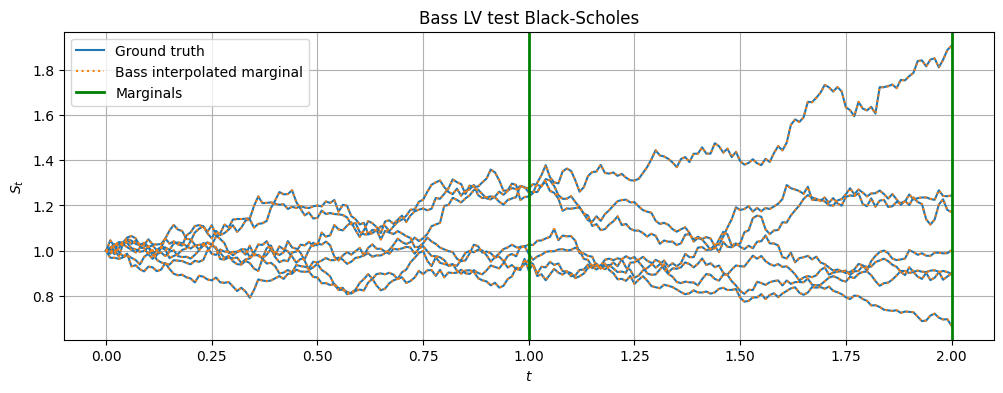

In [48]:
_, ax = plt.subplots(figsize=(12, 4))

handle_gt, *_ = ax.plot(t_flat, S_t_gt.T, c="C0")
handle_bass, *_ = ax.plot(t_flat, S_t_bass.T, c="C1", ls=":")
handle_marginal = ax.axvline(m1.tenor, c="g", lw=2)
handle_marginal = ax.axvline(m2.tenor, c="g", lw=2)

ax.set_xlabel("$t$")
ax.set_ylabel("$S_t$")
ax.set_title("Bass LV test Black-Scholes")
ax.grid()
ax.legend(
    [
        handle_gt,
        handle_bass,
        handle_marginal,
    ],
    [
        "Ground truth",
        "Bass interpolated marginal", 
        "Marginals",
    ],
)

plt.show()